In [2]:
import pandas as pd
import numpy as np
import seaborn as sns


### Pregunta 58: Observe una muestra aleatoria de los comentarios de las acciones realizadas por usuario o ips antes de ser bloqueados. Observe otra muestra de comentarios de acciones de todos

Logs csv tiene 12188946. Por la limitada memoria de mi computadora, voy a procesarlo por fragmentos al csv

La clave esta en que me piden antes de ser bloqueados. Y ademas lo que se me pide es la accion antes del primer bloqueo. Entonces lo que hago es : consigo primer bloqueo. Reviso el log matcheando con los elementos que no sean bloqueos y me fijo cual es el log que tiene la menor distancia con la accion de primer bloqueo


In [ ]:
columnas=['timestamp','action','title']
bloqueo_usuarios_mas_temprano=pd.read_csv("logs.csv",usecols=columnas)
bloqueo_usuarios_mas_temprano.dropna(inplace=True)
bloqueo_usuarios_mas_temprano=bloqueo_usuarios_mas_temprano.loc[bloqueo_usuarios_mas_temprano['action']=='block',['timestamp','title']]
bloqueo_usuarios_mas_temprano['Usuario_bloqueado']=bloqueo_usuarios_mas_temprano['title'].str.replace("Usuario:",'')
bloqueo_usuarios_mas_temprano=bloqueo_usuarios_mas_temprano.loc[:,['timestamp','Usuario_bloqueado']]
bloqueo_usuarios_mas_temprano['Usuario_bloqueado']=bloqueo_usuarios_mas_temprano['Usuario_bloqueado'].astype("string")
bloqueo_usuarios_mas_temprano=bloqueo_usuarios_mas_temprano.groupby('Usuario_bloqueado').agg('min').reset_index()

#### Limpieza de datos
Tengo un archivo muy grande para tenerlo todo en memoria. Sabiendo que entre los valores de los usuarios bloqueados tenemos una mezcla de usernames, ids y direcciones ip, se va a procesar los logs para cada uno de estos valores.

##### Direcciones ip

In [4]:
columnas=['timestamp','contributor_ip','action']
aux_df=pd.read_csv("logs.csv",usecols=columnas)

/home/tomas/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Me quedo con las acciones no bloqueantes

In [5]:
aux_df=aux_df.loc[aux_df['action']!='block',['timestamp','contributor_ip']]

Saco aquellos registros que no tengan uno timestamp o ip

In [6]:
aux_df.dropna(inplace=True)

In [10]:
ip_logs=aux_df

De aca en adelante, el df que tenga los datos timestamp,ip se va a llamar ip_logs

El df se va a guardar en el archivo csv "ip_fecha_logs.csv"

In [11]:
ip_logs.to_csv("ip_fecha_logs.csv")

#### User IDs

In [2]:
columnas=['timestamp','contributor_id','action']
aux_df=pd.read_csv("logs.csv",usecols=columnas)

In [3]:
aux_df=aux_df.loc[aux_df['action']!='block',['timestamp','contributor_id']]

In [4]:
aux_df.dropna(inplace=True)

In [7]:
id_logs=aux_df

De aca en adelante, el dataframe que tenga timestamp, id del usuario que hizo la accion estara en el dataframe id_logs

In [8]:
id_logs.to_csv("id_fecha_logs.csv")

#### UserNames

In [3]:
columnas=['timestamp','contributor_username','action']
aux_df=pd.read_csv("logs.csv",usecols=columnas)

In [4]:
aux_df=aux_df.loc[aux_df['action']!='block',['timestamp','contributor_username']]

In [5]:
aux_df=aux_df.dropna()

In [7]:
username_df=aux_df

De aca en adelante, el dataframe que tenga timestamp, username estara en el dataframe username_df

In [8]:
username_df.to_csv("username_fecha_logs.csv")

In [16]:
username_df.columns

Index(['timestamp', 'contributor_username'], dtype='object')

#### Procesamiento de los datos 
La consigna pide encontrar los comentarios para la ultima accion que hizo un usuario antes de que lo bloquearan. Tengo los logs del identificador del usuario y del timestamp de la accion. Al mismo tiempo tengo el identificador del usuario bloqueado y el timestamp de su primer bloqueo. Entonces lo que se va a hacer es unir estos dos dataframes con un inner join, calcular la diferencia de tiempo entre las acciones en el log y la accion de bloqueo para cada usuario bloqueado, y quedarme con el más chico. Una vez que tengo eso, sumo la diferencia de tiempo al momento del bloqueo y ya tengo la accion pedida

###### Procesamiento: Username

In [13]:
columnas=['Usuario_bloqueado','timestamp']
bloqueo_usuario_mas_temprano=pd.read_csv("fecha_usuario_bloqueado.csv",usecols=columnas)

In [18]:
bloqueo_usuario_mas_temprano=bloqueo_usuario_mas_temprano.rename(columns={'Usuario_bloqueado':'contributor_username','timestamp':'timestamp_bloqueo'})

In [19]:
username_df=username_df.merge(bloqueo_usuario_mas_temprano,on='contributor_username')

In [22]:
username_df['timestamp']=pd.to_datetime(username_df.timestamp).dt.tz_convert(None)

In [24]:
username_df['timestamp_bloqueo']=pd.to_datetime(username_df.timestamp_bloqueo).dt.tz_convert(None)

In [25]:
username_df['time_diff']=username_df['timestamp']-username_df['timestamp_bloqueo']

In [27]:
username_df['time_diff']=username_df['time_diff'].astype('timedelta64[m]')

In [31]:
username_df=username_df.loc[username_df['time_diff']<0,['contributor_username','time_diff']]

In [34]:
username_df=username_df.groupby('contributor_username').agg('max').reset_index()

El resultado se va a guardar en el archivo csv "username_time_diff_mas_cercano.csv"

In [35]:
#mando el archivo que tiene la diferencia en minutos mas cercana a un csv para que no explote todo
username_df.to_csv("username_time_diff_mas_cercano.csv")

##### Procesamiento: ID

In [10]:
columnas=['Usuario_bloqueado','timestamp']
bloqueo_usuario_mas_temprano=pd.read_csv("fecha_usuario_bloqueado.csv",usecols=columnas)

In [11]:
bloqueo_usuario_mas_temprano=bloqueo_usuario_mas_temprano.rename(columns={'Usuario_bloqueado':'contributor_id','timestamp':'timestamp_bloqueo'})

In [6]:
columnas=['timestamp','contributor_id']
id_logs=pd.read_csv("id_fecha_logs.csv",usecols=columnas)

In [16]:
bloqueo_usuario_mas_temprano['contributor_id']=bloqueo_usuario_mas_temprano['contributor_id'].astype("string")

In [17]:
id_logs['contributor_id']=id_logs['contributor_id'].astype("string")

In [18]:
id_logs=id_logs.merge(bloqueo_usuario_mas_temprano, on='contributor_id')

In [19]:
id_logs.shape

(0, 3)

No hay ningun usuario que haya sido identificado por su ID entre los usuarios bloqueados

##### Procesamiento: User IP

In [20]:
columnas=['Usuario_bloqueado','timestamp']
bloqueo_usuario_mas_temprano=pd.read_csv("fecha_usuario_bloqueado.csv",usecols=columnas)

In [23]:
columnas=['timestamp','contributor_ip']
ip_logs=pd.read_csv("ip_fecha_logs.csv",usecols=columnas)

In [25]:
bloqueo_usuario_mas_temprano=bloqueo_usuario_mas_temprano.rename(columns={'Usuario_bloqueado':'contributor_ip','timestamp':'timestamp_bloqueo'})

In [27]:
bloqueo_usuario_mas_temprano['contributor_ip']=bloqueo_usuario_mas_temprano['contributor_ip'].astype("string")

In [28]:
ip_logs['contributor_ip']=ip_logs['contributor_ip'].astype("string")

In [30]:
ip_logs=ip_logs.merge(bloqueo_usuario_mas_temprano,on='contributor_ip')

In [33]:
ip_logs['timestamp']=pd.to_datetime(ip_logs.timestamp).dt.tz_convert(None)

In [34]:
ip_logs['timestamp_bloqueo']=pd.to_datetime(ip_logs.timestamp_bloqueo).dt.tz_convert(None)

In [36]:
ip_logs['time_diff']=ip_logs['timestamp']-ip_logs['timestamp_bloqueo']

In [37]:
ip_logs['time_diff']=ip_logs['time_diff'].astype('timedelta64[m]')

In [39]:
ip_logs=ip_logs.loc[ip_logs['time_diff']<0,['contributor_ip','time_diff']]

In [40]:
ip_logs=ip_logs.groupby('contributor_ip').agg('max').reset_index()

In [42]:
ip_logs.to_csv("userip_time_diff_mas_cercano.csv")

Ahora se tienen los usuarios bloqueados y su diferencia de tiempo. Se une con el archivo que tiene el primer bloqueo, se obtiene la fecha para cada usuario y se extrae el comentario pedido

In [24]:
columnas=['contributor_username','time_diff']
username_time_diff=pd.read_csv("username_time_diff_mas_cercano.csv",usecols=columnas)

In [25]:
columnas=['contributor_ip','time_diff']
ip_time_diff=pd.read_csv("userip_time_diff_mas_cercano.csv",usecols=columnas)

In [26]:
username_time_diff=username_time_diff.rename(columns={'contributor_username':'Usuario_bloqueado'})
ip_time_diff=ip_time_diff.rename(columns={'contributor_ip':'Usuario_bloqueado'})

In [27]:
blocked_user_time_diff=pd.concat([username_time_diff,ip_time_diff])

In [28]:
blocked_user_time_diff

,Usuario_bloqueado,time_diff
0,! ! ! ! ! ! ! ! ! ! ! ! ! ! HAGGEⓇ? 123,-5.0
1,!! !!ПОМОГИТЕ СЕСТРЕ НА ОПЕРАЦИЮ!! !!,-62.0
2,"!""·$%&",-1771436.0
3,!23455666A!wee,-1532142.0
4,!2o%Uv6PHBj6JfgYmfgqVx!SCEBEP4,-5944.0
...,...,...
4854,99.106.76.104,-31.0
4855,99.190.136.211,-4.0
4856,99.203.143.116,-526.0
4857,99.203.28.110,-646.0


In [29]:
columnas=['Usuario_bloqueado','timestamp']
primer_bloqueo_usuario=pd.read_csv("fecha_usuario_bloqueado.csv",usecols=columnas)

In [30]:
accion_anterior_bloqueo=primer_bloqueo_usuario.merge(blocked_user_time_diff,on='Usuario_bloqueado')

In [31]:
accion_anterior_bloqueo['timestamp']=pd.to_datetime(accion_anterior_bloqueo.timestamp).dt.tz_convert(None)

In [32]:
accion_anterior_bloqueo['time_diff']=accion_anterior_bloqueo['time_diff'].astype('timedelta64[m]')

In [33]:
accion_anterior_bloqueo['timestamp_accion_anterior']=accion_anterior_bloqueo['timestamp']+accion_anterior_bloqueo['time_diff']

In [34]:
accion_anterior_bloqueo=accion_anterior_bloqueo.loc[:,['Usuario_bloqueado','timestamp_accion_anterior']]

Se tiene el timestamp de la accion anterior, se guarda en un csv

In [35]:
accion_anterior_bloqueo.to_csv("accion_anterior_bloqueo.csv")

##### Resolucion
Se tiene el timestamp de la ultima accion y el usuario. Falta encontrar los comentarios

###### Resolucion-username

In [33]:
columnas_username=['timestamp','contributor_username','comment']

In [34]:
username_logs=pd.read_csv("logs.csv",usecols=columnas_username)

In [35]:
username_logs.dropna(inplace=True)

In [52]:
username_logs=username_logs.rename(columns={'contributor_username':'Usuario_bloqueado'})

In [ ]:
username_logs['timestamp']=pd.to_datetime(username_logs.timestamp).dt.tz_convert(None)

In [56]:
accion_anterior_bloqueo=accion_anterior_bloqueo.rename(columns={'timestamp_accion_anterior':'timestamp'})

In [57]:
accion_anterior_bloqueo.dtypes

Usuario_bloqueado            object
timestamp            datetime64[ns]
dtype: object

In [58]:
resolucion_username=username_logs.merge(accion_anterior_bloqueo, on=['Usuario_bloqueado','timestamp'])

In [60]:
resolucion_username.to_csv("resolucion_username.csv")

###### Resolucion-ip

In [36]:
accion_anterior_bloqueo.shape

(100241, 2)

In [44]:
accion_anterior_bloqueo=accion_anterior_bloqueo.rename(columns={'timestamp_accion_anterior':'timestamp'})

In [37]:
columnas_ip=['timestamp','contributor_ip','comment']

In [38]:
ip_logs=pd.read_csv("logs.csv",usecols=columnas_ip)

/home/tomas/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [39]:
ip_logs.dropna(inplace=True)

In [40]:
ip_logs=ip_logs.rename(columns={'contributor_ip':'Usuario_bloqueado'})

In [42]:
ip_logs['timestamp']=pd.to_datetime(ip_logs.timestamp).dt.tz_convert(None)

In [45]:
resolucion_ip=ip_logs.merge(accion_anterior_bloqueo, on=['Usuario_bloqueado','timestamp'])

In [47]:
resolucion_ip.to_csv("resolucion_ip.csv")

### Resultados
Mostramos las muestras aleatorias pedidas

In [53]:
columnas=['timestamp','Usuario_bloqueado','comment']
resolucion_username=pd.read_csv("resolucion_username.csv",usecols=columnas)
resolucion_ip=pd.read_csv("resolucion_ip.csv",usecols=columnas)

In [55]:
comentarios_previos=pd.concat([resolucion_username,resolucion_ip])

In [65]:
comentarios_previos['comment']

,timestamp,Usuario_bloqueado,comment
68,2020-07-02 14:38:27,2601:281:8180:50E0:42C:FC5F:CF53:367C,Página creada con «<!--NO SE PONE ESTO: {{d|g1...
69,2020-07-10 13:45:42,200.74.119.64,Página creada con « {{Portal asociado|Chile}} ...
70,2020-07-19 08:24:28,168.196.202.191,Página creada con «Donpelis.com sitio web naci...
71,2020-07-30 19:47:03,177.102.109.140,Página creada con «{{Infobox royalty|title=Kin...
72,2020-08-01 17:41:03,190.232.153.149,Creado por: HSRJ.
73,2020-08-09 18:40:38,187.244.94.185,Página creada con «{{Ficha de serie de televis...
74,2020-08-26 16:00:22,179.36.124.232,Página creada con «Stentor Caudatus It is the ...
75,2020-09-05 18:36:33,187.237.14.200,Página creada con «Joven mexicano considerado ...
76,2020-10-01 21:41:17,177.249.56.219,Página creada con «Ely.cats '''si lees esto'''...
77,2020-10-05 16:39:15,2600:387:0:982:0:0:0:53,"Página creada con «{| class=""infobox"" style=""f..."


El valor de la muestra aleatoria no se encuentra especificada en el enunciado. Se decide que el mismo sea especificado por el usuario del notebook al momento de su ejecucion.(se pone 20 solo para especificar algo)

In [116]:
tamanio_muestra_aleatoria = 20

In [ ]:
muestra_aleatoria_comentarios_usuarios_previo_a_bloqueo=comentarios_previos.loc[:tamanio_muestra_aleatoria,:]['comment']

Se pide a su vez una muestra aleatoria de los comentarios para los usuarios en general

In [119]:
columnas=['comment']
muestra_aleatoria_comentarios_general=pd.read_csv("logs.csv",usecols=columnas,nrows=tamanio_muestra_aleatoria)

In [120]:
muestra_aleatoria_comentarios_general

,comment
0,el contenido era: 'Si aprendés Pensamiento Cie...
1,el contenido era: '{{destruir}}en algun lugar ...
2,el contenido era: '#REDIRECT [[Flash]]'
3,Sin información de origen ni de licencia. Hay ...
4,Sustituida por [[commons:Image:Heckert_GNU.png]]
5,vandalismo grosero
6,"Logotipo Comuna de La Florida, derecho público..."
7,Fotografía aérea instantánea de los videos de ...
8,"Pablo Zalaquett, Alcalde de La Florida {{PD}}"
9,Está en commons


# Parte de la visualizacion

In [1]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

## Dataset: comportamiento de la soja

In [96]:
columnas=['Fecha','Cierre']

In [97]:
soja_behaviour=pd.read_csv("datasetRofex4 - datasetRofex2.csv",usecols=columnas)

In [98]:
soja_behaviour.dtypes

Fecha      object
Cierre    float64
dtype: object

In [99]:
soja_behaviour['Fecha']=pd.to_datetime(soja_behaviour['Fecha'])

In [103]:
soja_behaviour['Mes']=soja_behaviour['Fecha'].dt.month

In [105]:
soja_behaviour['Anio']=soja_behaviour['Fecha'].dt.year

In [107]:
soja_behaviour_post_2010=soja_behaviour.loc[soja_behaviour['Anio'] >2010,:]

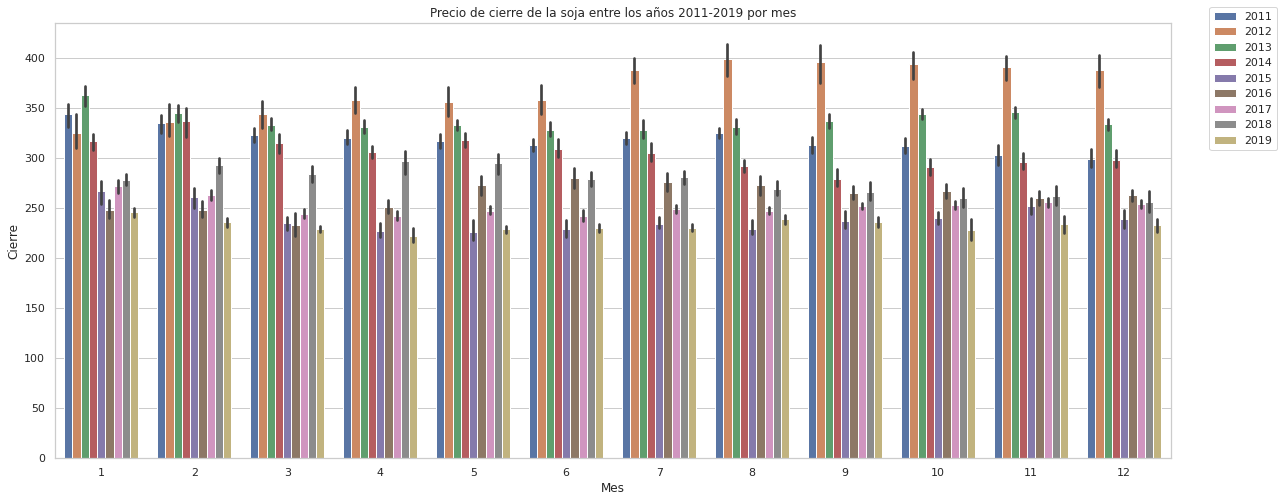

In [111]:
fig, ax = plt.subplots(figsize=(20,8))
plt.title("Precio de cierre de la soja entre los años 2011-2019 por mes")
sns.barplot(x='Mes',y='Cierre',hue='Anio',data=soja_behaviour_post_2010)
ax.legend(bbox_to_anchor=(1.1, 1.05))

In [44]:
columnas=['Fecha','Cierre']
soja_trimestre=pd.read_csv("datasetRofex4 - datasetRofex2.csv",usecols=columnas)

In [45]:
soja_trimestre['Fecha']=pd.to_datetime(soja_trimestre['Fecha'])

In [46]:
soja_trimestre.dtypes

Fecha     datetime64[ns]
Cierre           float64
dtype: object

In [47]:
soja_trimestre['Año']=pd.DatetimeIndex(soja_trimestre['Fecha']).year

In [48]:
soja_trimestre=soja_trimestre.loc[:,['Cierre','Año']]

In [49]:
soja_trimestre=soja_trimestre.rename(columns={'Cierre': 'Precio_de_ajuste'})

<AxesSubplot:title={'center':'Precio de ajuste de la soja por año'}, xlabel='Año', ylabel='Precio_de_ajuste'>

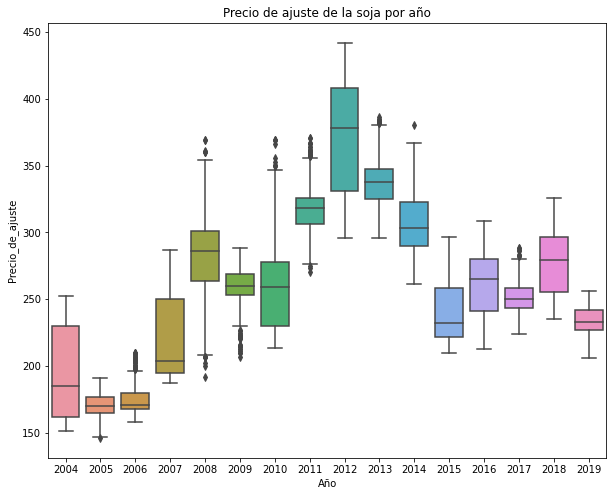

In [81]:
fig, ax = plt.subplots(figsize=(10,8))
plt.title("Precio de ajuste de la soja por año")
sns.boxplot(x=soja_trimestre['Año'],y=soja_trimestre['Precio_de_ajuste'])

## Dataset: prediccion de exitos

In [30]:
exit_predict=pd.read_csv("Entrenamieto_ECI_2020.csv")

In [31]:
exit_predict=exit_predict.loc[:,['Region','Product_Family','Stage']]

In [32]:
exit_predict['Stage']=exit_predict['Stage'].apply(lambda x: 1 if str(x)=='Closed Won' else -1)

In [33]:
exit_predict=exit_predict.groupby(['Region','Product_Family']).agg('mean').reset_index()

In [34]:
exit_2d=exit_predict.pivot(index='Region',columns='Product_Family',values='Stage')

Voy a competar aquellas combinaciones sobre las cuales no tengo datos como  que tienen igual probabilidad de funcionar como de no

In [35]:
exit_2d=exit_2d.fillna(0)

<AxesSubplot:title={'center':'Probabilidad de Exito'}, xlabel='Product_Family', ylabel='Region'>

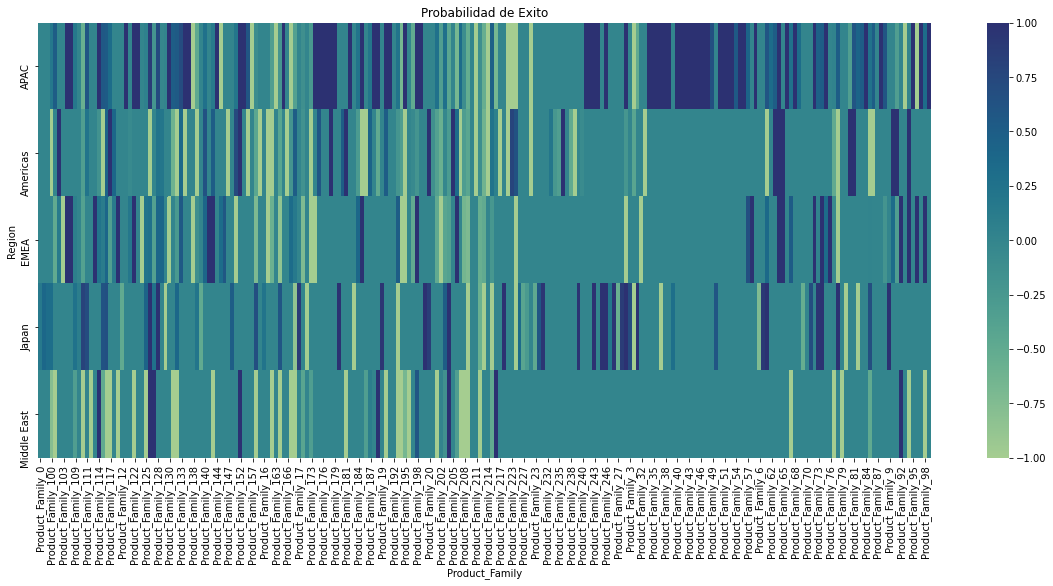

In [52]:
fig, ax = plt.subplots(figsize=(20,8))
plt.title("Probabilidad de Exito")
sns.heatmap(exit_2d,cmap='crest')

Analisis para solo aquellos donde hubo exito

In [83]:
exit_predict_df=pd.read_csv("Entrenamieto_ECI_2020.csv")

In [84]:
exit_predict_df['Stage']=exit_predict_df['Stage'].apply(lambda x: 1 if str(x)=='Closed Won' else -1)

In [85]:
exitos=exit_predict_df.copy()

In [86]:
exitos=exitos.loc[exitos['Stage']==1,['Region','Delivery_Year','Stage']]

In [87]:
exitos=exitos.loc[:,['Region','Delivery_Year']]

<AxesSubplot:title={'center':'Distribución de éxitos a lo largo de los años por región'}, xlabel='Region', ylabel='Delivery_Year'>

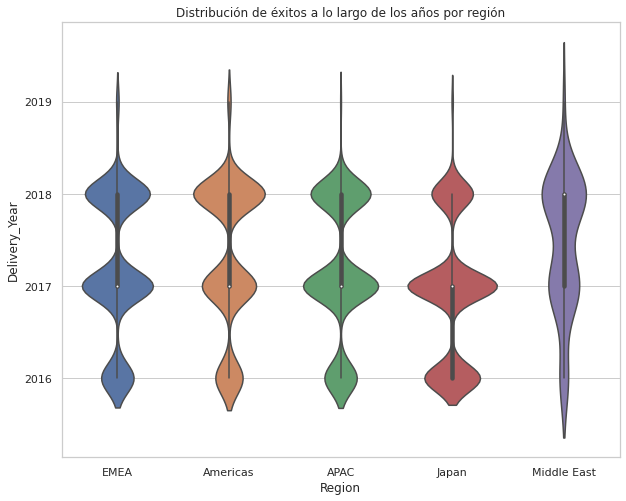

In [112]:
fig, ax = plt.subplots(figsize=(10,8))
sns.set_theme(style="whitegrid")
plt.title("Distribución de éxitos a lo largo de los años por región")
sns.violinplot(data=exitos,x='Region',y='Delivery_Year')

In [91]:
fallas=exit_predict_df.copy()

In [92]:
fallas=fallas.loc[fallas['Stage']==-1,['Region','Delivery_Year','Stage']]

In [93]:
fallas=fallas.loc[:,['Region','Delivery_Year']]

<AxesSubplot:title={'center':'Distribución de fallos a lo largo de los años por región'}, xlabel='Region', ylabel='Delivery_Year'>

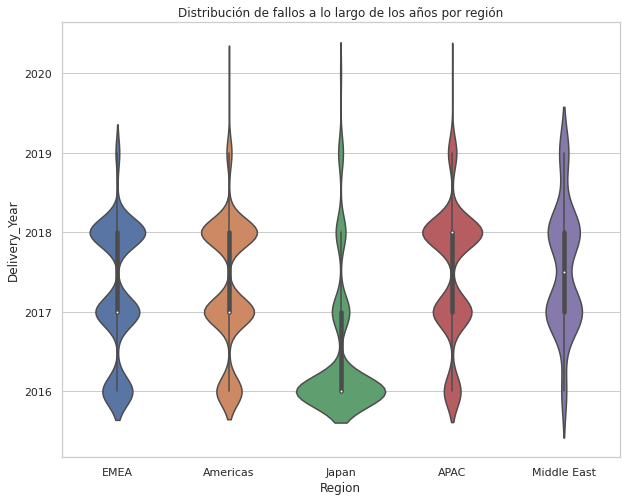

In [114]:
fig, ax = plt.subplots(figsize=(10,8))
sns.set_theme(style="whitegrid")
plt.title("Distribución de fallos a lo largo de los años por región")
sns.violinplot(data=fallas,x='Region',y='Delivery_Year')

## Datos: DengueAI

La variable que se quiere predecir es el numero de casos para la combinacion año, semana del año ciudad

Lo que voy a hacer entonces, es armar un histograma con la cantidad de casos por ciudad para una combinacion temporal año semana del año

In [53]:
dengue_features=pd.read_csv("dengue_features_train.csv")

In [54]:
dengue_targets=pd.read_csv("dengue_labels_train.csv")

In [55]:
dengue_targets.isna().sum()

city           0
year           0
weekofyear     0
total_cases    0
dtype: int64

In [56]:
dengue_targets.city.value_counts()

sj    936
iq    520
Name: city, dtype: int64

In [57]:
dengue_targets.columns

Index(['city', 'year', 'weekofyear', 'total_cases'], dtype='object')

In [58]:
sj_city=dengue_targets.loc[dengue_targets['city']=='sj',['city','year','total_cases']]

In [59]:
iq_city=dengue_targets.loc[dengue_targets['city']=='iq',['city','year','total_cases']]

In [60]:
sj_city=sj_city.groupby(['city','year']).agg('sum').reset_index()

In [61]:
iq_city=iq_city.groupby(['city','year']).agg('sum').reset_index()

In [62]:
bar_df=pd.concat([sj_city,iq_city],axis=0)

In [76]:
bar_df['city']= bar_df['city'].apply(lambda x: "San juan" if x=='sj' else "Iquitos")

<AxesSubplot:title={'center':'Casos de dengue por año'}, xlabel='year', ylabel='total_cases'>

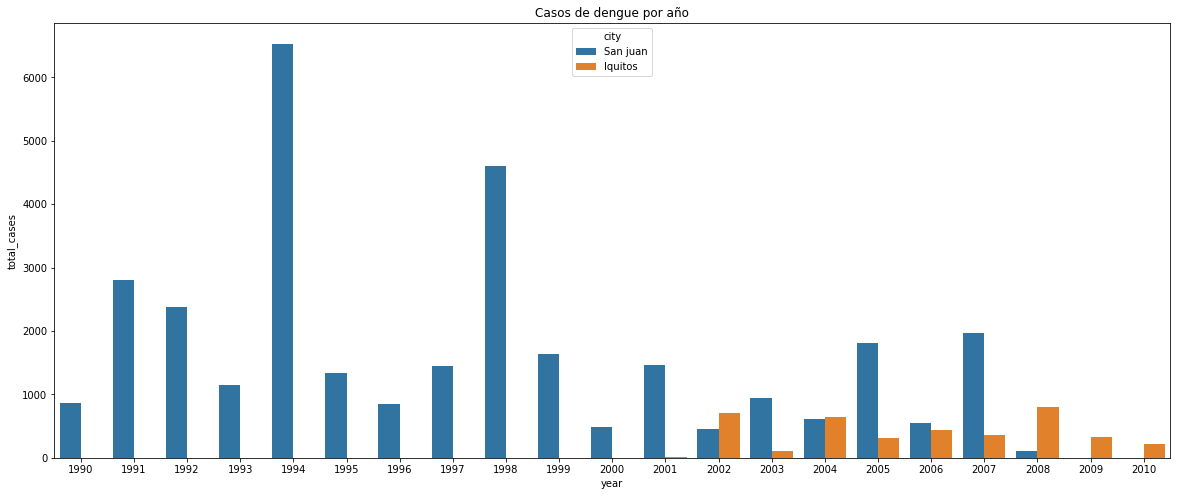

In [78]:
fig, ax = plt.subplots(figsize=(20,8))
plt.title("Casos de dengue por año")
sns.barplot(x='year',y='total_cases',hue='city',data=bar_df)


In [85]:
dengue_targets['total_cases'].value_counts()

0      100
6       71
3       70
5       70
2       69
      ... 
135      1
137      1
141      1
142      1
461      1
Name: total_cases, Length: 135, dtype: int64

Voy a hacer un grafico que muestre el numero de veces que se dieron n casos para la ciudad sj durante el periodo de tiempo que tenemos como dato

In [63]:
frecuencia_casos_sj=dengue_targets.loc[dengue_targets['city']=='sj',['total_cases','year']]

In [64]:
frecuencia_casos_sj=frecuencia_casos_sj.groupby('total_cases').agg('count').reset_index()

In [65]:
frecuencia_casos_sj=frecuencia_casos_sj.rename(columns={'year':'frecuencia'})

<AxesSubplot:title={'center':'Frecuencia para cada numero de casos en la ciudad de San Juan'}, xlabel='total_cases', ylabel='frecuencia'>

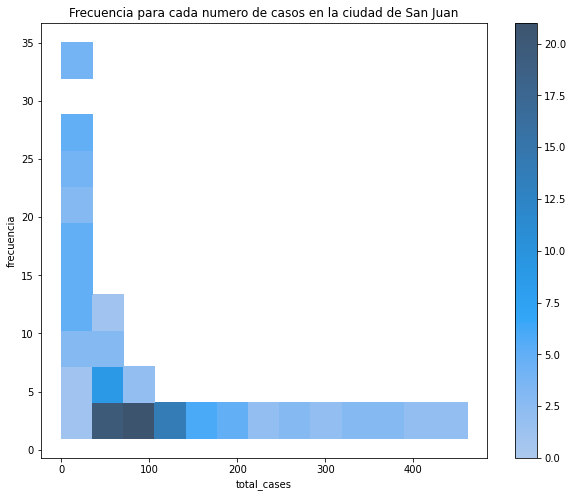

In [79]:
fig, ax = plt.subplots(figsize=(10,8))
plt.title("Frecuencia para cada numero de casos en la ciudad de San Juan")
sns.histplot(data=frecuencia_casos_sj, x='total_cases', y='frecuencia',cbar=True)

In [68]:
frecuencia_casos_iq=dengue_targets.loc[dengue_targets['city']=='iq',['total_cases','year']]

In [69]:
frecuencia_casos_iq=frecuencia_casos_iq.groupby('total_cases').agg('count').reset_index()

In [70]:
frecuencia_casos_iq=frecuencia_casos_iq.rename(columns={'year':'frecuencia'})

<AxesSubplot:title={'center':'Frecuencia para cada numero de casos en la ciudad de Iquitos'}, xlabel='total_cases', ylabel='frecuencia'>

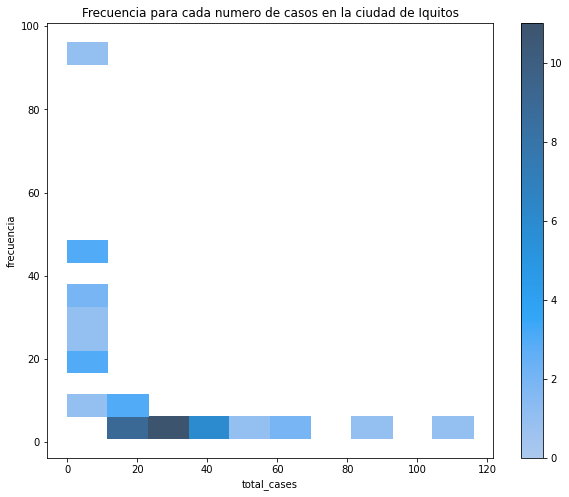

In [80]:
fig, ax = plt.subplots(figsize=(10,8))
plt.title("Frecuencia para cada numero de casos en la ciudad de Iquitos")
sns.histplot(data=frecuencia_casos_iq, x='total_cases', y='frecuencia',cbar=True)